<a href="https://colab.research.google.com/github/RichardMWarburton/ExploringCUAD/blob/Dev/Governing%20Law%20Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition

This notebook investigates extracting named entities from the the governing law annotations.





## The Data

CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review

https://arxiv.org/abs/2103.06268

This code is an adaptation of the scrape.py file avaliable on the github repository for CUAD.  It has been adapted to run in Jypter notebooks and allow us to step throght the coding line by line.`

## 1: Import Packages & Define Useful Functions

In [2]:
from zipfile import ZipFile
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from random import sample, choice
import numpy as np
import pandas as pd
import re
import string
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import AgglomerativeClustering

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer


import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

from pprint import pprint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

## 2: Download repository and extract data

In [4]:
#Download CUAD git repository
if not os.path.exists('main.zip'):
  !wget --no-check-certificate https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
  !unzip -q main.zip

#If it has not already been extracted, extract the contents of data.zip
if not os.path.exists('cuad-main/data'):
  os.makedirs('cuad-main/data')

if not os.path.exists('cuad-main/data/CUADv1.json'):
  extract_zip('cuad-main/data.zip','cuad-main/data/')

#Download a manualy curated set of labels for the full CUAD data. 
if not os.path.exists('labels3.txt'):
  !wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt

--2021-07-20 11:17:43--  https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main [following]
--2021-07-20 11:17:43--  https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [   <=>              ]  17.77M  20.3MB/s    in 0.9s    

2021-07-20 11:17:44 (20.3 MB/s) - ‘main.zip’ saved [18631176]

--2021-07-20 11:17:45--  https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt
Resolving raw.githubusercont

In [5]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        contract_data = json.loads(line)

### 2.1: Read in Label Data & Generate Look Up Dictionary

In [6]:
#Initate storage for labels look up (LU)
labels_LU = {}

#Read in labels data
with open('labels3.txt','r',encoding ='UTF-8') as infile:
  for line in infile:
    #Remove trailing special characters and split on tab
    data = line.strip().split(sep='\t')
    #Add name and label to labels_LU dictionary
    labels_LU[data[0]] = data[1]

The look up returns one error, most likely due to the accented E and a disparity of encoding.  This will be forced to 'Marketing Agreement' manually for now (EITHER SORT OR PROVIDE EXAMPLE)

### 2.2: Extract Raw Contract Data

In [7]:
#ser reg ex expression for characters to remove from contract contest
spec_chars = '\\n|\\t|\\t'

#Set number of contracts in data
num_contracts = len(contract_data['data'])

#Initate dictionary to store raw contract data
raw_contracts = defaultdict(list)

#for each contract
for i in range(num_contracts):
  #Append the title, contract text and character length of text to the raw_contracts dictionary
  raw_contracts['contract title'].append(contract_data['data'][i]['title'])
  raw_contracts['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' ) #<- manual error trap applied here (see below)
  
  #Parse raw text and process to remove breaks
  raw_text = contract_data['data'][i]['paragraphs'][0]['context']
  clean_text = re.sub(spec_chars,'',raw_text)

  #Split clean text in to sentances and tokens
  sentance_text = clean_text.split(sep = '. ')
  token_text = clean_text.split(sep = ' ')

  #Append text to the respective key in the raw_contracts dictionary
  raw_contracts['raw text'].append(raw_text)
  raw_contracts['clean text'].append(clean_text)
  raw_contracts['sentance text'].append(sentance_text)
  raw_contracts['token text'].append(token_text)
  
  #Add character, sentance and token counts to raw_contracts dictionary
  raw_contracts['character count'].append(len(raw_text))
  raw_contracts['sentance count'].append(len(sentance_text))
  raw_contracts['token count'].append(len(token_text))


### 2.3: Extract Clause Specific Data

In [8]:
#Define the number of clauses
num_clauses = 41

#initate dictioanry to store caluse data
clause_data = defaultdict(list)

#For each contract
for i in range(num_contracts):
  #for each clause
  for j in range(num_clauses):
    #for each found clause annotation
    for k in range(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'])): 
      #Add the contract title
      clause_data['contract title'].append(contract_data['data'][i]['title'])
      clause_data['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' )  #<- manual error trap applied here
      clause_data['clause'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['id'].split(sep='__')[1])
      clause_data['annotation'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text'])
      clause_data['annotation start'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['answer_start'])
      clause_data['annotation length'].append(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']))


## 3: Cleaning data and extracting a single clause

In [9]:
#Initate dataframe of all clause data
clause_df = pd.DataFrame(clause_data)

#Convert to lower case
#clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.lower())

#Remove any formating characters or multiple spaces and replace with a single space
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x))

#Remove punctuation from the string
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [10]:
#Define clause of interest
clause_of_interest = 'Governing Law'

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['annotation'].values

#Identify where there are multiple annotations per contract
titles,counts = np.unique(of_interest_data['contract title'],return_counts =True)
dups = titles[counts >= 2]

#Output Analysis
print('There are {} contracts with \'{}\' annotations'.format(*(titles.shape[0],clause_of_interest)))
print('There are {} contracts with more than one annotation'.format(dups.shape[0]))

#output duplicate annotations anc contract titles
dup_df = of_interest_data[of_interest_data['contract title'].isin(dups)][['contract title','annotation']]

There are 437 contracts with 'Governing Law' annotations
There are 25 contracts with more than one annotation


In [11]:
#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
#append annotation to a default dict list with contract as key
for i in of_interest_data.index:
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['annotation']].values[0]
  combined_annotations_list[name].append(annotation)

#Produce a singel string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

In [12]:
#Build array of contract names and concatenated annotations
contracts = np.array(list(combined_annotations_string.keys()))
combined_annotations = list(combined_annotations_string.values())

## Section 4: Named Entity Extraction

SpaCy has been chosen as the named entity recognition approach as it provided better performance in isolating locations and laws

### Section 4.1 SpaCy

## Section 4: Parsing Annotations for Named Entities

In [14]:
nlp = en_core_web_sm.load()

#Build new features
new_features = []

for annotation in combined_annotations:
  annotation_GPEs = []
  
  doc = nlp(annotation)

  for X in doc.ents:
    #First pass to capture entities
    if X.label_ == 'GPE' or X.label_ == 'LANGUAGE':
      if X.text not in annotation_GPEs:
        annotation_GPEs.append(X.text)
  
  #If no entities found, foce to lower case and re analyise
  if annotation_GPEs == []:
    doc = nlp(annotation.lower())

    for X in doc.ents:
      if X.label_ == 'GPE' or X.label_ == 'LANGUAGE':
        if X.text not in annotation_GPEs:
          annotation_GPEs.append(X.text)

  new_features.append(' '.join(annotation_GPEs))

In [15]:
#Define stopwords list
stop_words = stopwords.words('english') +['hereof','thereof']

def lower_case(x):
  """Function to return a lowecase value of a string x"""
  return x.lower()

def remove_stop_words(x):
  """Function to remove stop words from a string x """  
  return ' '.join([word for word in x.split(sep=' ') if word not in stop_words])

def coerce_tokens(x):
  ret = x.replace('new york','newyork')
  ret = ret.replace('new jersey','newjersey')
  ret = ret.replace('hong kong','hongkong')
  ret = ret.replace('san antonio','sanantonio')
  return ret

In [16]:
#initiate new_features as an np array
new_features = np.array(new_features)

#Clean New Features
new_features = np.array(list(map(lower_case,new_features)))
new_features = np.array(list(map(remove_stop_words,new_features)))
new_features = np.array(list(map(coerce_tokens,new_features)))

#Tokenize new_features
#new_features = np.array(list((map(nltk.word_tokenize,new_features))),dtype=object)

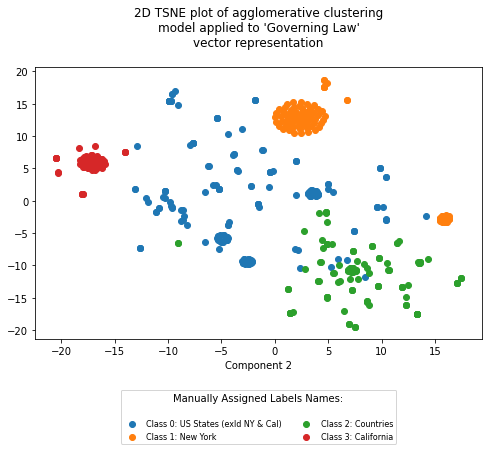

In [17]:
#Count Vectorize new_feature vector
cv = CountVectorizer(stop_words = 'english')
vectorized_features = cv.fit_transform(new_features).toarray()

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(vectorized_features)
x = X_tsne[:,0]
y = X_tsne[:,1]

#Fit agglomerative clister model with two clusters to split groups
cluster = AgglomerativeClustering(n_clusters=4).fit(vectorized_features)

#Based on manual analysis of the data
class_names = {0:'US States (exld NY & Cal)',1:'New York',2:'Countries',3:'California'}

#Get data points for plot
x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

plt.figure(figsize =(8,5))
#Plot, highlighting each labeld class
for i in np.unique(labels):
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class {}: {}'.format(*(str(i),class_names[i])))

plt.title('2D TSNE plot of agglomerative clustering\nmodel applied to \'Governing Law\'\nvector representation\n')
plt.xlabel('Component 1')
plt.xlabel('Component 2')

plt.legend(loc ='lower center', bbox_to_anchor = (0.5,-0.4),title='Manually Assigned Labels Names:\n',fontsize = 8,ncol=2)
plt.show()

In [18]:
bag_of_clauses = {}

for i in range(len(contracts)):
  bag_of_clauses[contracts[i]] = {clause_of_interest:vectorized_features[i,:]}


In [19]:
bag_of_clauses

{'2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement': {'Governing Law': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEMENT': {'Governing Law': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT': {'Governing Law': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0